In [9]:
# trying a simple training example
# the custom model
import torch
import torch.nn as nn
from my_extension import (
    CustomLinear, 
    CustomReLU
)


import numpy as np



In [59]:
"""Define a few models for comparison, including a standard (all built in ops), custom, and mixed model
"""

class CustomNeuralNet(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 hidden_size_2, 
                 hidden_size_3,
                 output_size):
        super(CustomNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, hidden_size_2)
        self.ac2 = CustomReLU()
        self.fc3 = CustomLinear(hidden_size_2, hidden_size_3)
        self.ac3 = CustomReLU()
        self.fc4 = CustomLinear(hidden_size_3, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        return x

#3 comparing the custom net with a standard net
class StandardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(StandardNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=False)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class MixedNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(MixedNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.ac1 = nn.ReLU()
        self.fc2 = CustomLinear(hidden_size, hidden_size_2)
        self.ac2 = nn.ReLU()
        self.fc3 = CustomLinear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

class TinyNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TinyNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x


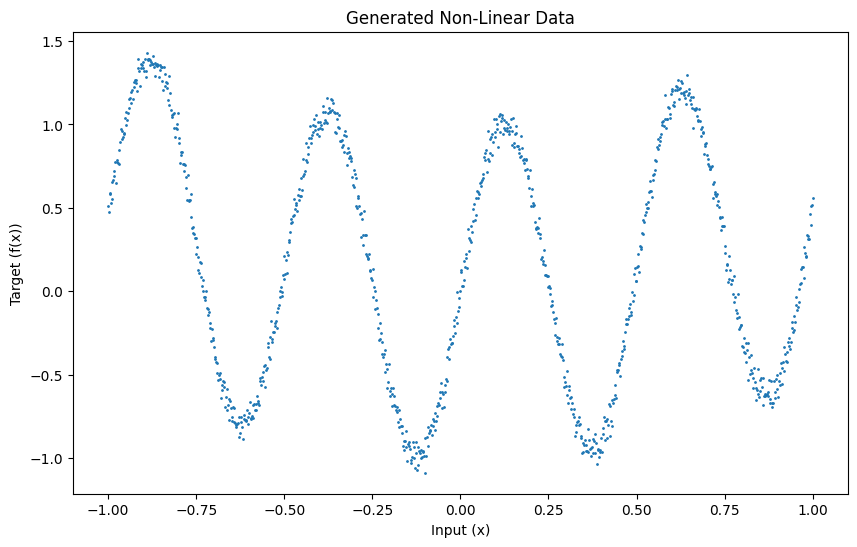

In [60]:
# Settings
num_samples = 1000  # Number of data points
x_range = [-1, 1]  # Range of x values
noise_factor = 0.05  # Noise factor for the data

# Generate input features
inputs = torch.linspace(x_range[0], x_range[1], steps=num_samples).unsqueeze(1)

# Generate targets based on the non-linear function
targets = torch.sin(4 * np.pi * inputs) + 0.5 * torch.pow(inputs, 2)

# Add noise to targets
targets_noisy = targets + torch.randn(targets.shape) * noise_factor

# Plot the generated data
plt.figure(figsize=(10, 6))
plt.scatter(inputs.numpy(), targets_noisy.numpy(), s=1)
plt.title("Generated Non-Linear Data")
plt.xlabel("Input (x)")
plt.ylabel("Target (f(x))")
plt.show()

# Split into training and testing sets
train_ratio = 0.8
num_train = int(num_samples * train_ratio)
train_inputs = inputs[:num_train]
train_targets = targets_noisy[:num_train]

test_inputs = inputs[num_train:]
test_targets = targets_noisy[num_train:]

# Calculate mean and standard deviation of the inputs
inputs_mean = train_inputs.mean()
inputs_std = train_inputs.std()

# Normalize (scale and center) the inputs
train_inputs_normalized = (train_inputs - inputs_mean) / inputs_std
test_inputs_normalized = (test_inputs - inputs_mean) / inputs_std

# Calculate mean and standard deviation of the targets
targets_mean = train_targets.mean()
targets_std = train_targets.std()

# Normalize (scale and center) the targets
train_targets_normalized = (train_targets - targets_mean) / targets_std
test_targets_normalized = (test_targets - targets_mean) / targets_std


In [61]:
# move to the MPS device
train_inputs = train_inputs_normalized.to('mps')
train_targets = train_targets_normalized.to('mps')

In [62]:
# Initialize the networks and move to MPS device
num_features = 1
hidden_size = 5
hidden_size_2 = 10
hidden_size_3 = 5
output_size = 1

standard_model = None
standard_model = StandardNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2, 
    output_size=1
).to('mps')

custom_model = None
custom_model = CustomNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    hidden_size_3=hidden_size_3,
    output_size=output_size
).to('mps')

mixed_model = None
mixed_model = MixedNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')


tiny_model = None
tiny_model = TinyNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    output_size=output_size
).to('mps')

In [63]:
# set the model to the model of choice
model = standard_model

# set criterion and choose adam optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Simple Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_inputs)
    loss = criterion(outputs, train_targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    # if (epoch+1) % 100 == 0:
    #     for name, param in model.named_parameters():
    #         print(f"Gradients of {name}: {param.grad}")


Epoch [10/1000], Loss: 0.9220
Epoch [20/1000], Loss: 0.9231
Epoch [30/1000], Loss: 0.9229
Epoch [40/1000], Loss: 0.9221
Epoch [50/1000], Loss: 0.9220
Epoch [60/1000], Loss: 0.9221
Epoch [70/1000], Loss: 0.9221
Epoch [80/1000], Loss: 0.9220
Epoch [90/1000], Loss: 0.9220
Epoch [100/1000], Loss: 0.9220
Epoch [110/1000], Loss: 0.9220
Epoch [120/1000], Loss: 0.9220
Epoch [130/1000], Loss: 0.9220
Epoch [140/1000], Loss: 0.9220
Epoch [150/1000], Loss: 0.9220
Epoch [160/1000], Loss: 0.9220
Epoch [170/1000], Loss: 0.9220
Epoch [180/1000], Loss: 0.9220
Epoch [190/1000], Loss: 0.9220
Epoch [200/1000], Loss: 0.9220
Epoch [210/1000], Loss: 0.9220
Epoch [220/1000], Loss: 0.9220
Epoch [230/1000], Loss: 0.9220
Epoch [240/1000], Loss: 0.9220
Epoch [250/1000], Loss: 0.9220
Epoch [260/1000], Loss: 0.9220
Epoch [270/1000], Loss: 0.9220
Epoch [280/1000], Loss: 0.9220
Epoch [290/1000], Loss: 0.9220
Epoch [300/1000], Loss: 0.9220
Epoch [310/1000], Loss: 0.9220
Epoch [320/1000], Loss: 0.9220
Epoch [330/1000],

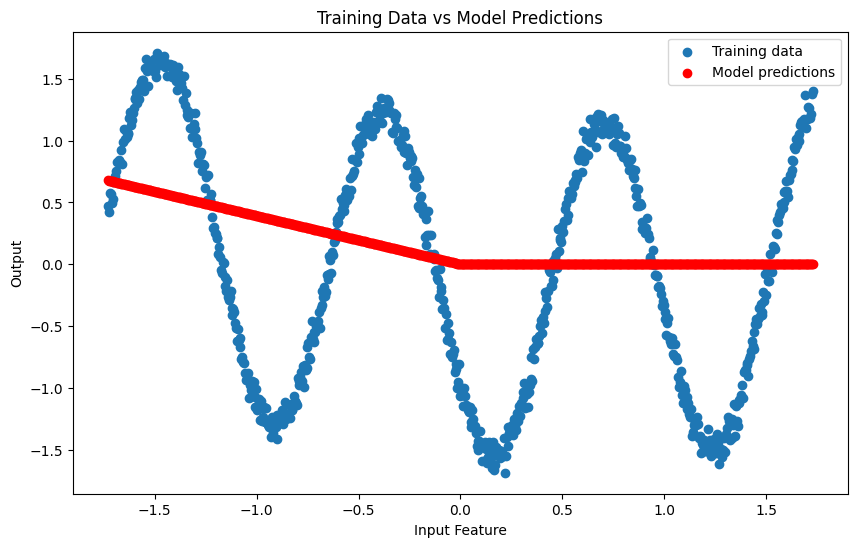

In [64]:
import matplotlib
import matplotlib.pyplot as plt

# Assuming `train_inputs` and `train_outputs` are your training data
# And `model` is your trained model

# Move the data to the same device as the model
#train_inputs, train_outputs = train_inputs.to('mps'), train_targets.to('mps')

# Get predictions from the model
with torch.no_grad():
    predictions = model(train_inputs)

# Convert tensors to numpy for plotting
train_inputs_np = train_inputs.cpu().numpy()
train_outputs_np = train_targets.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Assuming a single feature for simplicity in plotting
plt.figure(figsize=(10, 6))
plt.scatter(train_inputs_np[:, 0], train_outputs_np[:, 0], label='Training data')
plt.scatter(train_inputs_np[:, 0], predictions_np[:, 0], label='Model predictions', color='red')
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.legend()
plt.title('Training Data vs Model Predictions')
plt.show()


In [46]:
train_inputs[:, 1]

tensor([-1.2007e+00, -1.2541e+00, -1.2847e+00, -1.3017e+00, -1.2477e+00,
        -1.2512e+00, -1.2339e+00, -1.2623e+00, -1.2411e+00, -1.2560e+00,
        -1.2590e+00, -1.2547e+00, -1.2454e+00, -1.2632e+00, -1.2710e+00,
        -1.2551e+00, -1.2433e+00, -1.2542e+00, -1.2625e+00, -1.2696e+00,
        -1.3025e+00, -1.2476e+00, -1.2348e+00, -1.2414e+00, -1.2352e+00,
        -1.2763e+00, -1.2543e+00, -1.2452e+00, -1.2492e+00, -1.2119e+00,
        -1.2218e+00, -1.2228e+00, -1.2420e+00, -1.2368e+00, -1.2863e+00,
        -1.2675e+00, -1.2394e+00, -1.2428e+00, -1.2450e+00, -1.2301e+00,
        -1.2614e+00, -1.2239e+00, -1.2351e+00, -1.2949e+00, -1.2066e+00,
        -1.2429e+00, -1.2628e+00, -1.2604e+00, -1.2383e+00, -1.2480e+00,
        -1.2731e+00, -1.2249e+00, -1.2425e+00, -1.2339e+00, -1.2311e+00,
        -1.2665e+00, -1.2536e+00, -1.2858e+00, -1.2246e+00, -1.2491e+00,
        -1.1920e+00, -1.2252e+00, -1.2611e+00, -1.2075e+00, -1.2397e+00,
        -1.1959e+00, -1.2278e+00, -1.2197e+00, -1.2

In [ ]:
# vanishing gradient? 
for name, param in model.named_parameters():
    print(f"Gradients of {name}: {param.grad}")


In [ ]:
# vanishing gradient? 
for name, param in model.named_parameters():
    print(f"Values of {name}: {param}")


In [25]:
model

CustomNeuralNet(
  (fc1): CustomLinear(input_features=1, output_features=10)
  (ac1): CustomReLU(MPS-based ReLU)
  (fc2): CustomLinear(input_features=10, output_features=10)
  (ac2): CustomReLU(MPS-based ReLU)
  (fc3): CustomLinear(input_features=10, output_features=1)
)